<a href="https://colab.research.google.com/github/dvnananth/rasmitha/blob/main/FMNIST_CNN_ResNetCNN_WnB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# Step 0: Install WandB if not installed
!pip install -q wandb
# Step 1: Imports
import os
import gzip
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import wandb
import matplotlib.pyplot as plt

In [11]:
#STEP 2: Download Fashion-MNIST
!wget -N http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget -N http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget -N http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget -N http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

DATA_PATH = "/content"

--2026-02-01 15:22:46--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 3.5.135.113, 3.5.137.46, 3.5.121.28, ...
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|3.5.135.113|:80... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘train-images-idx3-ubyte.gz’ not modified on server. Omitting download.

--2026-02-01 15:22:46--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 3.5.135.113, 3.5.137.46, 3.5.121.28, ...
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|3.5.135.113|:80... connected.
HTTP request sent, awai

In [12]:
#STEP 3: Load IDX files
#IDX structure [magic number][num items][rows][cols][data...]

#Loading Images & Labels
def load_images(path):
    with gzip.open(path, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    return data.reshape(-1, 28, 28)
def load_labels(path):
    with gzip.open(path, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)
    return labels

# Training & Testing Data splitting
images_train = load_images(DATA_PATH + "/train-images-idx3-ubyte.gz")
labels_train = load_labels(DATA_PATH + "/train-labels-idx1-ubyte.gz")

images_test = load_images(DATA_PATH + "/t10k-images-idx3-ubyte.gz")
labels_test = load_labels(DATA_PATH + "/t10k-labels-idx1-ubyte.gz")

#data checking 28828 size 60k images/ labels training and 10k testing
print(images_train.shape)
print(labels_train.shape)
print(images_test.shape)

train_losses = []
test_losses = []


(60000, 28, 28)
(60000,)
(10000, 28, 28)


In [13]:
class FMNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = torch.tensor(self.images[idx], dtype=torch.float32).unsqueeze(0)
        img = img / 255.0              # normalization
        lbl = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, lbl
train_data = FMNISTDataset(images_train, labels_train)
test_data  = FMNISTDataset(images_test, labels_test)

trainloader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2)
testloader  = DataLoader(test_data, batch_size=128, shuffle=False, num_workers=2)


In [14]:
class ResBoundBlock(nn.Module):
    def __init__(self, channels, alpha=0.2):
        super().__init__()
        self.alpha = alpha

        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(channels)
        )

        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.block(x)
        return self.relu(x + self.alpha * out)


In [15]:
class MiniResNetFMNIST(nn.Module):
    def __init__(self):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)     # 28 → 14
        )

        self.stage1 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),    # 14 → 7
            ResBoundBlock(64),
            ResBoundBlock(64)
        )

        self.stage2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            ResBoundBlock(128),
            ResBoundBlock(128)
        )

        self.gap = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)


In [16]:
model = MiniResNetFMNIST()

wandb.init(
    project="fmnist-resnet",
    name="MiniResNet_ResBound",
    config={
        "model": "MiniResNet + ResBound",
        "residual_alpha": 0.2,
        "depth": "2+2 residual blocks",
        "learning_rate": 1e-3,
        "batch_size": 128,
        "optimizer": "AdamW",
        "scheduler": "StepLR",
        "epochs": 6
    }
)

wandb.watch(model, log="parameters", log_freq=500)


batch_loss,█▂▁
epoch,▁▁▁
batch_loss,0.75707
epoch,0


In [17]:
# Step 8: Loss and optimizer
#loss_fn = nn.NLLLoss()
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay =1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [18]:
# Step 9A: Evaluation function (DEFINE FIRST)
def evaluate(model, dataloader, loss_fn):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in dataloader:
            output = model(data)
            loss = loss_fn(output, target)

            total_loss += loss.item() * data.size(0)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)

    avg_loss = total_loss / total
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy


In [19]:
train_losses = []
test_losses = []

epochs = wandb.config.epochs

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(trainloader):
        optimizer.zero_grad(set_to_none=True)

        output = model(data)
        loss = loss_fn(output, target)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        running_loss += loss.item() * data.size(0)
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)

    avg_loss = running_loss / len(trainloader.dataset)
    train_acc = 100 * correct / total
    train_losses.append(avg_loss)

    scheduler.step()

    test_loss, test_acc = evaluate(model, testloader, loss_fn)
    test_losses.append(test_loss)

    wandb.log({"epoch": epoch, "train_loss": avg_loss, "train_accuracy": train_acc, "test_loss": test_loss, "test_accuracy": test_acc})

    print(f"Epoch {epoch}: "f"Train Loss={avg_loss:.4f}, "f"Train Acc={train_acc:.2f}%, "f"Test Loss={test_loss:.4f}, "f"Test Acc={test_acc:.2f}%")


Epoch 0: Train Loss=0.9312, Train Acc=81.65%, Test Loss=0.8780, Test Acc=83.73%
Epoch 1: Train Loss=0.7655, Train Acc=89.23%, Test Loss=0.7634, Test Acc=88.31%
Epoch 2: Train Loss=0.7288, Train Acc=90.83%, Test Loss=0.7400, Test Acc=89.68%
Epoch 3: Train Loss=0.7061, Train Acc=91.73%, Test Loss=0.7261, Test Acc=89.42%
Epoch 4: Train Loss=0.6905, Train Acc=92.50%, Test Loss=0.7203, Test Acc=90.58%
Epoch 5: Train Loss=0.6534, Train Acc=94.04%, Test Loss=0.6954, Test Acc=91.37%
Epoch 6: Train Loss=0.6433, Train Acc=94.61%, Test Loss=0.6742, Test Acc=92.32%


KeyboardInterrupt: 

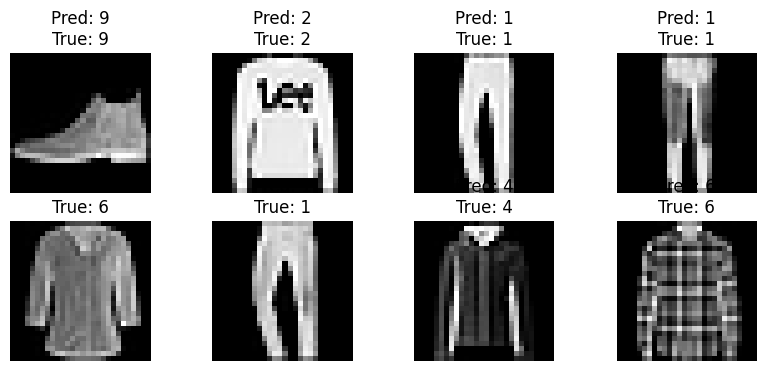

epoch,▁▂▃▅▆▇█
test_accuracy,▁▅▆▆▇▇█
test_loss,█▄▃▃▃▂▁
train_accuracy,▁▅▆▆▇██
train_loss,█▄▃▃▂▁▁
epoch,6
test_accuracy,92.32
test_loss,0.6742
train_accuracy,94.61333
train_loss,0.64331


In [20]:
# Step 11: Visualize some test images with predictions
data_iter = iter(testloader)
images, labels = next(data_iter)
outputs = model(images)
_, preds = torch.max(outputs, 1)

fig = plt.figure(figsize=(10,4))
for idx in range(8):
    ax = fig.add_subplot(2,4,idx+1)
    ax.imshow(images[idx].cpu().squeeze(), cmap='gray')
    ax.set_title(f"Pred: {preds[idx].item()}\nTrue: {labels[idx].item()}")
    ax.axis('off')
plt.show()

# Finish W&B run
wandb.finish()

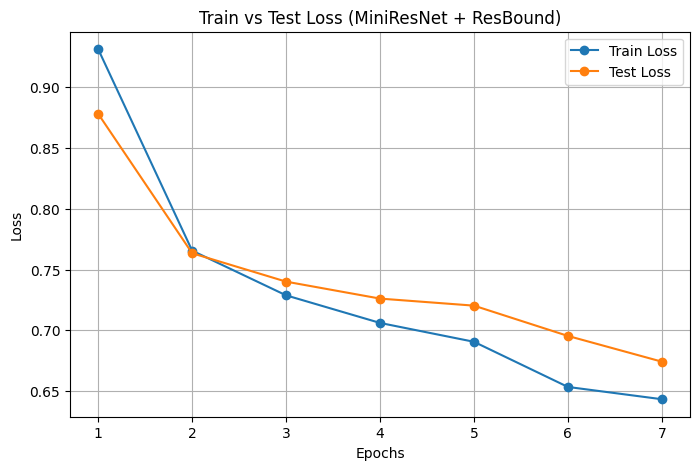

In [22]:
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_losses, marker='o', label="Train Loss")
plt.plot(epochs_range, test_losses, marker='o', label="Test Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss (MiniResNet + ResBound)")
plt.legend()
plt.grid(True)
plt.show()
